In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,LSTM,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
np.random.seed(0)
tf.random.set_seed(0)

In [28]:
!pip install scikit-learn

In [29]:
df=pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [30]:
df['Logpassengers']=np.log(df['Passengers'])

In [31]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [32]:
df['Diff']=df['Logpassengers'].diff()

In [33]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [35]:
series=df['Diff'].dropna().to_numpy()

T=12
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T,1)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (131, 12, 1) Y.shape (131,)


In [48]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [49]:
#RNN
i=Input(shape=(T,1))
x=LSTM(24)(i)
x=Dense(1)(x)
model=Model(i,x)

In [50]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 24)                2496      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.compile(loss='mse',optimizer='adam')

In [52]:
r=model.fit(Xtrain,Ytrain,epochs=150,validation_data=(Xtest,Ytest))

Epoch 1/150
4/4 [==============================] - 2s 126ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 5/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 7/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 8/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 9/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 10/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 11/150
4/4 [

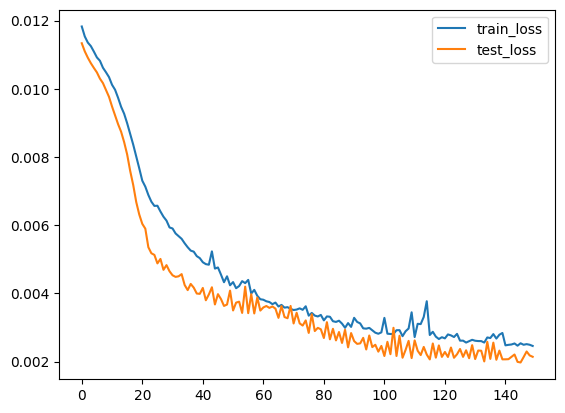

In [53]:
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='test_loss')
plt.legend();

In [54]:
train_idx[:T+1] = False

In [55]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 15ms/step


In [57]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['Logpassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [59]:
# Last-known train value
last_train = train.iloc[-1]['Logpassengers']

In [60]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

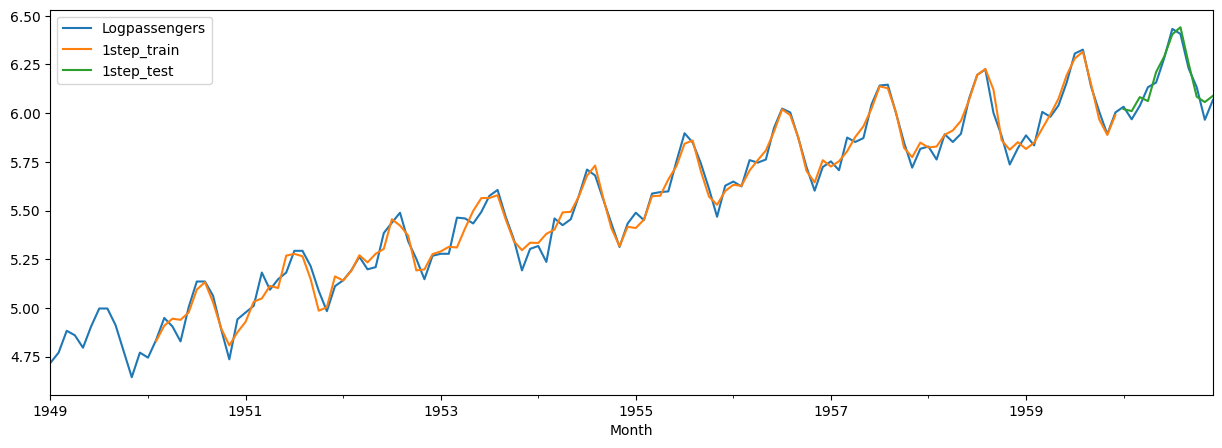

In [62]:

df[['Logpassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [63]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 18ms/step


In [64]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

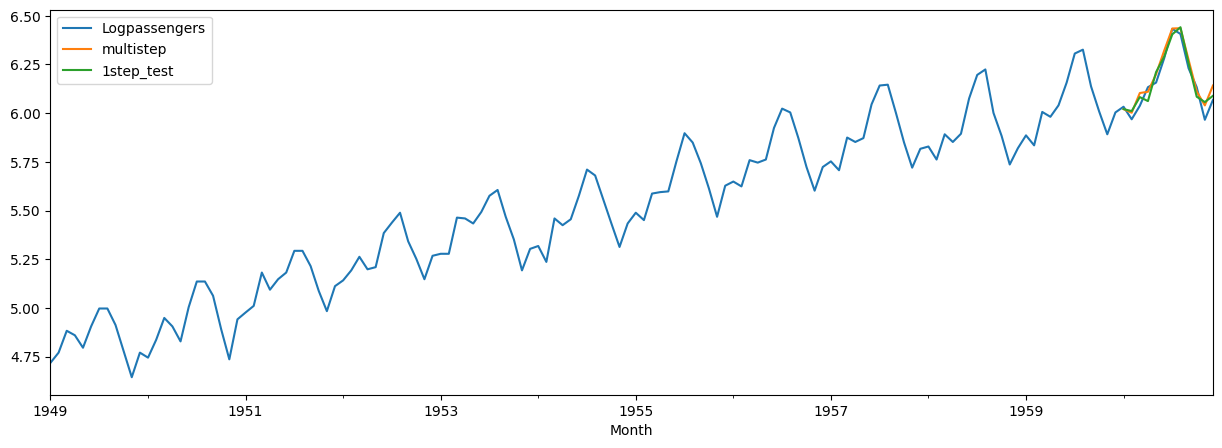

In [66]:
# plot 1-step and multi-step forecast
df[['Logpassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [67]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (120, 12, 1) Y.shape (120, 12)


In [68]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [98]:

i = Input(shape=(Tx, 1))
x = LSTM(36, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [99]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [100]:
model.compile(loss='mse',optimizer='adam',)

In [101]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=500,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/500
4/4 [==============================] - 2s 129ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0112 - val_loss: 0.0117
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 7/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 8/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 9/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 10/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 11/500
4/4 [

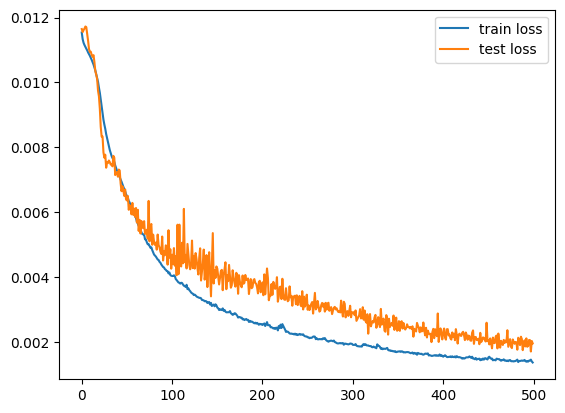

In [102]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [103]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [104]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 15ms/step


In [105]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [106]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

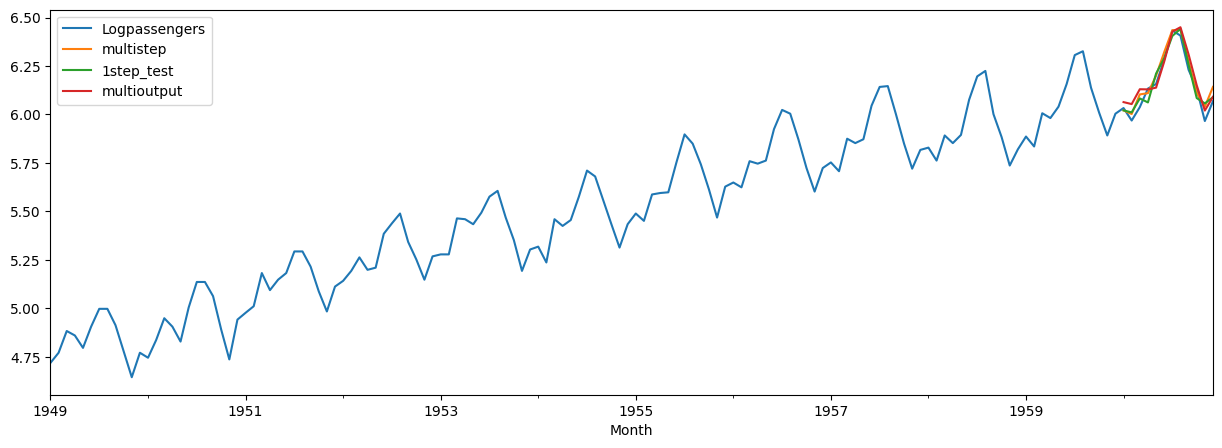

In [107]:
# plot all forecasts
cols = ['Logpassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [117]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(36, return_sequences=True)(i)
x = LSTM(36, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [118]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [119]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [120]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=500,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/500
4/4 [==============================] - 4s 241ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 3/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 7/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 8/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 9/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 10/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 11/500
4/4 [

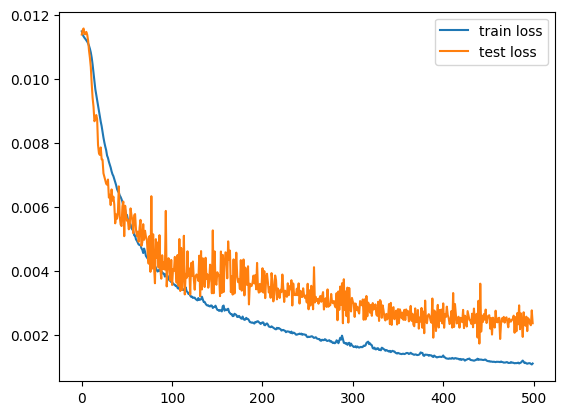

In [121]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();


In [122]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [123]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/1 [==============================] - 0s 18ms/step


In [124]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

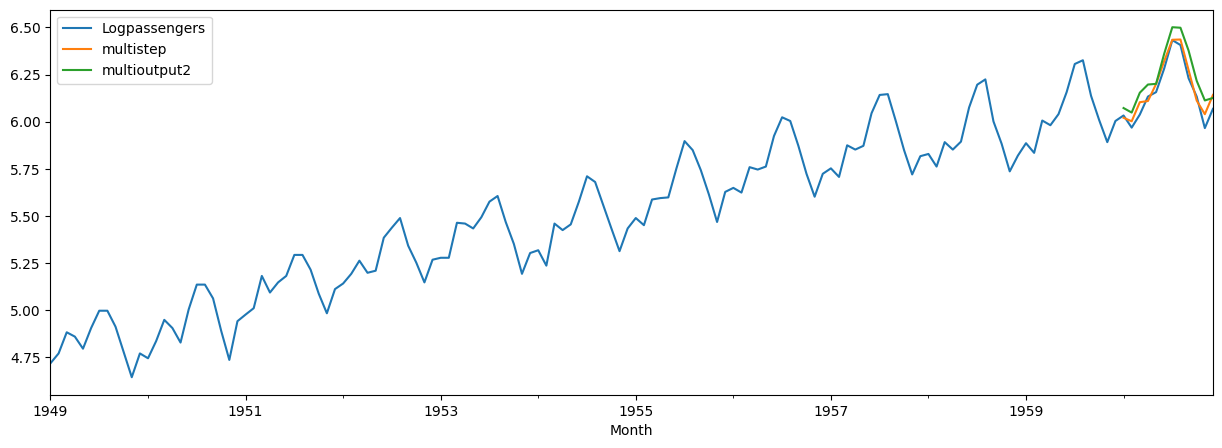

In [126]:
# plot all forecasts
cols = ['Logpassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5));

In [128]:
from sklearn.metrics import mean_absolute_percentage_error

In [129]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['Logpassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.006281300897613741
multi-output MAPE: 0.006314485709288103
multi-output (2 LSTMs) MAPE: 0.013784601398990627
